## Policy Playground  
This is code for loading and testing saved policies.

In [1]:
import tensorflow as tf
import numpy as np

import tensorflow_probability as tfp
from tf_agents.environments import tf_py_environment
from tf_agents.policies import scripted_py_policy

import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
#plt.ioff() 

#from RNN_Env_P2 import Env_P2_N
import sys
sys.path.insert(1, '/home/jovyan/Masterarbeit/reinforce-one/Environment')
sys.path.insert(1, '/home/jovyan/Masterarbeit/reinforce-one/Environment/Simplifications')

from Env import Env
from Env_Simple import Env_S
from Env_S_A import Env_S_A
from Env_LS import Env_LS

In [2]:
max_episode_length=1000
num_herds = 2   # plotting currently only works for 2 herds
total_population = 300

pol_R4_D = tf.compat.v2.saved_model.load('Runs/R4_D/3000*BEST')
pol_R21 = tf.compat.v2.saved_model.load('Runs/R21/149000*BEST')
pol_R26 = tf.compat.v2.saved_model.load('Runs/R26/2000*BEST')
pol_R27 = tf.compat.v2.saved_model.load('Runs/R27/44000*BEST')

py_env = Env(num_herds = num_herds, total_population = total_population, fix_episode_length = True, average_episode_length = 200)
eval_env = tf_py_environment.TFPyEnvironment(py_env)

py_env_S = Env_S(num_herds = num_herds, total_population = total_population, fix_episode_length=True, average_episode_length = 200)
eval_env_S = tf_py_environment.TFPyEnvironment(py_env_S)

py_env_S_A = Env_S_A(num_herds = num_herds, total_population = total_population, fix_episode_length=True, average_episode_length = 200)
eval_env_S_A = tf_py_environment.TFPyEnvironment(py_env_S_A)

py_env_LS = Env_LS(num_herds = num_herds, total_population = total_population, fix_episode_length=True, average_episode_length = 200)
eval_env_LS = tf_py_environment.TFPyEnvironment(py_env_LS)

In [3]:
def test_policy(environment, policy, num_episodes=50, num_herds = 2):
    if isinstance(environment, tf_py_environment.TFPyEnvironment):
        total_return = 0.0
        cullsteps = 0 
        actions = []
        if environment.action_spec().shape[0] == num_herds:
            only_culls = True
        else:
            only_culls = False
        for e in range(num_episodes):

            time_step = environment.reset()
            if isinstance(policy, scripted_py_policy.ScriptedPyPolicy):
                policy_state = policy.get_initial_state() # remember where in the script we were
            else:
                #print(policy.get_initial_state(batch_size=train_env.batch_size()))
                policy_state = policy.get_initial_state(batch_size=1) # other policies without memory
            episode_return = 0.0
            i=0
            while not time_step.is_last():
                i+=1
                action_step = policy.action(time_step, policy_state)
                if only_culls:
                    for j in range (0, num_herds):
                        if environment == eval_env_S_A:
                            if action_step.action[0][j] >= 0.5:
                                cullsteps += 1
                            
                        elif action_step.action[0][j] > 0:
                            cullsteps += 1
                else:
                    for j in range (num_herds, num_herds*2):
                        if action_step.action[0][j] >= 0.5:
                            cullsteps += 1
                if e == np.int32(num_episodes/2):
                    if environment == eval_env_S_A:
                        act = np.zeros(np.size(action_step.action[0]), np.float32)
                        for j in range(0, num_herds):
                            if action_step.action[0][j] >= 0.5:
                                act[j] = 1.
                            else:
                                act[j] = 0.
                        actions.append(act)
                    elif environment == eval_env_LS or environment == eval_env :
                        act = np.zeros(np.size(action_step.action[0]), np.float32)
                        act[0] = action_step.action[0][0]
                        act[1] = action_step.action[0][1]
                        for j in range(num_herds, num_herds*2):
                            if action_step.action[0][j] >= 0.5:
                                act[j] = 1.
                            else:
                                act[j] = 0.
                        actions.append(act)
                    else:
                        actions.append(action_step.action[0])
                policy_state = action_step.state
                time_step = environment.step(action_step.action)
                episode_return += time_step.reward

            total_return += episode_return

        avg_return = total_return / num_episodes
        cullsteps /= num_episodes
        return avg_return, cullsteps, actions
    else:
        return None

In [4]:
 def plot_actions(action_list, environment):
        if environment.action_spec().shape[0] == num_herds:
            only_culls = True
        else:
            only_culls = False
        print(len(action_list))
        t = np.linspace(0, len(action_list), num=len(action_list))
        fig, (p1,p2) = plt.subplots(1, 2, figsize=(15,7))
        fig.suptitle('Actions over Time')
        p1.set_title('Tests over Time')
        p1.set_xlabel('Time')
        p1.set_ylabel('Number of Tests')
        p1.set_ylim(-0.1, 1.1)
        p2.set_title('Herd Replacements over Time')
        p2.set_xlabel('Time')
        p2.set_ylabel('Replacement Probability')
        p2.set_ylim(-0.1, 1.1) 
        n_tests_h1, n_tests_h2, replace_h1, replace_h2 = [], [], [], []
        for i in range(len(action_list)):
            if(only_culls):
                #n_tests_h1.append(action_list[i][0])
                #n_tests_h2.append(action_list[i][1])
                replace_h1.append(action_list[i][0])
                replace_h2.append(action_list[i][1])
            else:
                n_tests_h1.append(action_list[i][0])
                n_tests_h2.append(action_list[i][1])
                replace_h1.append(action_list[i][2])
                replace_h2.append(action_list[i][3])
        if not only_culls:
            p1.plot(t, n_tests_h1, color='black', label = 'Herd 1', marker = '', linestyle = '-',alpha=0.7)
            p1.plot(t, n_tests_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-',alpha=0.7)
        p2.plot(t, replace_h1, color='black', label = 'Herd 1', marker = '*', linestyle = '-',alpha=0.7)
        p2.plot(t, replace_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-',alpha=0.7)
        if not only_culls:
            p1.legend()
        p2.legend()
        return fig

In [8]:
 def plot_n_actions(action_list, environment, num_herds):
        # only for envs with 2 actions per herd per step
        colors = ['b', 'g', 'r', 'y', 'k']
        t = np.linspace(0, len(action_list), num=len(action_list))
        fig, (p1,p2) = plt.subplots(1, 2, figsize=(15,7))
        fig.suptitle('Actions over Time')
        p1.set_title('Tests over Time')
        p1.set_xlabel('Time')
        p1.set_ylabel('Number of Tests')
        p1.set_ylim(-0.1, 1.1)
        p2.set_title('Herd Replacements over Time')
        p2.set_xlabel('Time')
        p2.set_ylabel('Replacement Probability')
        p2.set_ylim(-0.1, 1.1) 
        tests, replace = [], []
        for i in range (len(action_list)):
            temp_tests = []
            temp_replace = []
            for j in range (0, num_herds):
                temp_tests.append(action_list[i][j])
                temp_replace.append(action_list[i][j+num_herds])
            tests.append(temp_tests)
            replace.append(temp_replace)
        tests = np.array(tests)
        replace = np.array(replace)
        for k in range (0, num_herds):
            tmp_label = 'Herd ' + str(k+1)
            p1.plot(t, tests[:,k], color=colors[(k % len(colors))], label = tmp_label, marker = '', linestyle = '-',alpha=0.7)
            p2.plot(t, replace[:,k], color=colors[(k % len(colors))], label = tmp_label, marker = '', linestyle = '-',alpha=0.7)
            
        p1.legend()
        p2.legend()
        return fig

Average Return:  tf.Tensor([-44.05632], shape=(1,), dtype=float32)
Cullsteps:  14.87


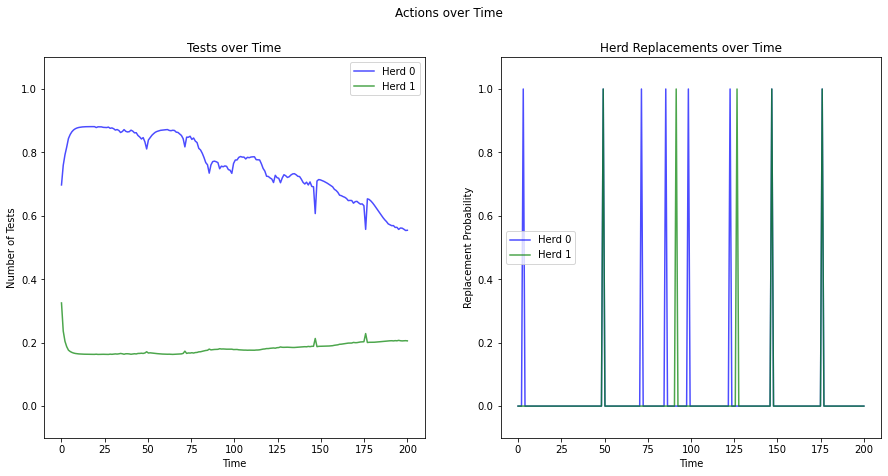

In [9]:
ret, cull, act = test_policy(eval_env, pol_R26, num_episodes = 200, num_herds = 2)
print('Average Return: ', ret)
print('Cullsteps: ', cull)
fig = plot_n_actions(act, eval_env,2)

Average Return:  tf.Tensor([-34.35757], shape=(1,), dtype=float32)
Average culls:  11.465
200


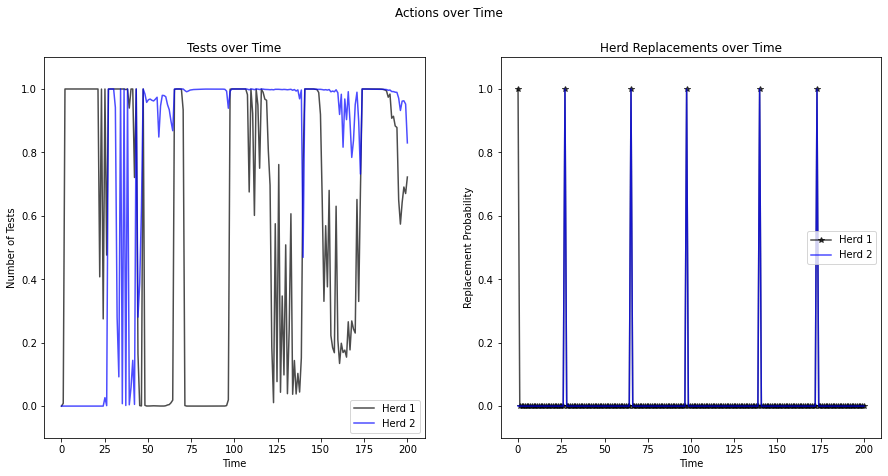

In [6]:
ret, cull, act = test_policy(eval_env, pol_R27, num_episodes = 200, num_herds = 2)
print('Average Return: ', ret)
print('Average culls: ', cull)
fig = plot_actions(act, eval_env)

Average Return:  tf.Tensor([-32.66042], shape=(1,), dtype=float32)
Cullsteps:  16.296
200


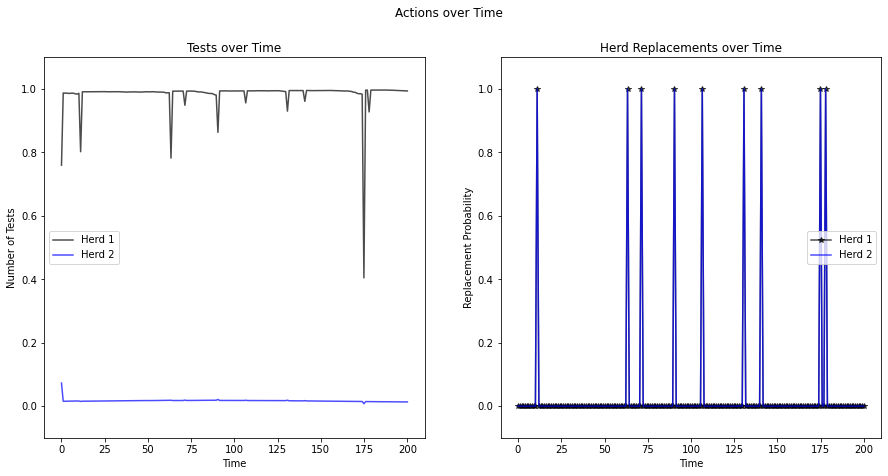

In [7]:
ret, cull, act = test_policy(eval_env, pol_R4_D, num_episodes = 1000, num_herds = 2)
print('Average Return: ', ret)
print('Cullsteps: ', cull)
fig = plot_actions(act, eval_env)